In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class TransformerNoiseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
        super(TransformerNoiseModel, self).__init__()
        self.embedding = nn.Linear(input_dim + 1, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        transformer_out = self.transformer(x)
        pred_noise = self.fc(transformer_out)
        return pred_noise

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [3]:
class GRUNoiseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUNoiseModel, self).__init__()
        self.gru = nn.GRU(input_dim + 1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        pred_noise = self.fc(gru_out)
        return pred_noise

In [4]:
class TimeGrad(nn.Module):
    def __init__(self, num_features, num_steps, hidden_dim=128, beta_min=0.1, beta_max=0.2, num_heads=4, num_layers=3):
        super(TimeGrad, self).__init__()
        self.num_features = num_features
        self.num_steps = num_steps
        self.beta_min = beta_min
        self.beta_max = beta_max
        
        # Linear schedule for betas
        self.betas = torch.linspace(self.beta_min, self.beta_max, self.num_steps)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

        # # Cosine schedule for betas
        # self.betas = self.cosine_beta_schedule(num_steps)
        # self.alphas = 1 - self.betas
        # self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        
        # Define the neural network for predicting noise
        # self.model = nn.Sequential(
        #     nn.Linear(num_features + 1, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, num_features)
        # )
        
        # Define the neural network for predicting noise
        self.model = GRUNoiseModel(num_features, hidden_dim)

        # Define the Transformer-based neural network for predicting noise
        # self.model = TransformerNoiseModel(num_features+1, hidden_dim, num_heads, num_layers)
        

    def cosine_beta_schedule(self, num_steps, s=0.008):
        """
        Cosine schedule for beta values.
        """
        steps = torch.linspace(0, num_steps, num_steps + 1)
        alphas_cumprod = torch.cos(((steps / num_steps) + s) / (1 + s) * (np.pi / 2)) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
        return torch.clip(betas, 0.0001, 0.9999)
        
    def forward_diffusion(self, x_0, t):
        """
        Forward diffusion process q(x_t | x_0)
        """
        alpha_bar_t = self.alpha_bar[t]
        noise = torch.randn_like(x_0)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise
    
    def reverse_diffusion(self, x_t, t):
        """
        Reverse diffusion process p(x_{t-1} | x_t)
        """
        t = torch.tensor([t], dtype=torch.long).to(x_t.device)
        t_embedded = t.float().repeat(x_t.shape[0], 1)
        x_t_and_t = torch.cat([x_t, t_embedded], dim=-1)
        pred_noise = self.model(x_t_and_t)
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1).expand_as(pred_noise)
        x_0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(self.alphas[t])
        return x_0_pred, pred_noise
        
    def p_sample(self, x_t, t):
        """
        Sample from the reverse process
        """
        x_0_pred, pred_noise = self.reverse_diffusion(x_t, t)
        beta_t = self.betas[t]
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)
        x_t_prev = torch.sqrt(self.alphas[t]) * x_0_pred + torch.sqrt(beta_t) * noise
        return x_t_prev

    def p_sample_loop(self, shape):
        """
        Loop over the reverse process to generate samples
        """
        x_t = torch.randn(shape).to(next(self.parameters()).device)
        print(x_t.shape)
        for t in reversed(range(self.num_steps)):
            x_t = self.p_sample(x_t, t)
        return x_t

def create_synthetic_data(num_samples, seq_length, num_features):
    t = np.linspace(0, 2 * np.pi, seq_length)
    data = []
    for _ in range(num_samples):
        sample = np.array([np.sin(t + np.random.uniform(-0.5, 0.5)) for _ in range(num_features)]).T
        sample += 0.1 * np.random.randn(seq_length, num_features)  # Add noise
        data.append(sample)
    return np.array(data)

# Create synthetic data
num_samples = 100
seq_length = 100
num_features = 2

synthetic_data = create_synthetic_data(num_samples, seq_length, num_features)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float32)

In [5]:
import torch
import torch.nn as nn

# TimeGrad with GRU
class TimeGradGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_length):
        super(TimeGradGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_length = seq_length

        # GRU to model the noise
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.t_embedding = nn.Embedding(seq_length, hidden_dim)

    def forward(self, x_t, t, h):
        t_embedded = self.t_embedding(t).unsqueeze(1).repeat(1, self.seq_length, 1)
        x_t_and_t = torch.cat([x_t, t_embedded], dim=-1)
        out, h = self.gru(x_t_and_t, h)
        pred_noise = self.fc(out)
        return pred_noise, h

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

In [6]:
def train(model, data, num_epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_0 in data:
            x_0 = x_0.to(device)
            t = torch.randint(0, model.num_steps, (1,), dtype=torch.long).item()
            x_t, noise = model.forward_diffusion(x_0, t)
            x_0_pred, pred_noise = model.reverse_diffusion(x_t, t)
            loss = criterion(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data)}")

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_steps = 500  # Number of diffusion steps
num_epochs = 100
lr = 1e-3

model = TimeGrad(num_features, num_steps).to(device)
train(model, synthetic_data, num_epochs, lr)

Epoch 1/100, Loss: 15.619243406057358
Epoch 2/100, Loss: 2.6708814615011214
Epoch 3/100, Loss: 1.6007045251131058
Epoch 4/100, Loss: 67.70364143170417
Epoch 5/100, Loss: 8.265695152580738
Epoch 6/100, Loss: 0.27830368265509603
Epoch 7/100, Loss: 0.11176733631640673
Epoch 8/100, Loss: 0.15098859280813484
Epoch 9/100, Loss: 0.06034719181945548
Epoch 10/100, Loss: 0.022776544310618194
Epoch 11/100, Loss: 0.02676539957523346
Epoch 12/100, Loss: 0.027481948700733484
Epoch 13/100, Loss: 0.02431938397232443
Epoch 14/100, Loss: 0.04076674914220348
Epoch 15/100, Loss: 0.033255009229760615
Epoch 16/100, Loss: 0.06426562798907981
Epoch 17/100, Loss: 0.02250280815118458
Epoch 18/100, Loss: 0.24710554570076057
Epoch 19/100, Loss: 0.033450988348340614
Epoch 20/100, Loss: 0.547513528498821
Epoch 21/100, Loss: 0.9823710861010477
Epoch 22/100, Loss: 1.8675138801336288
Epoch 23/100, Loss: 0.015359055297449232
Epoch 24/100, Loss: 0.01428154758992605
Epoch 25/100, Loss: 0.012767946796957403
Epoch 26/100, 

torch.Size([100, 2])


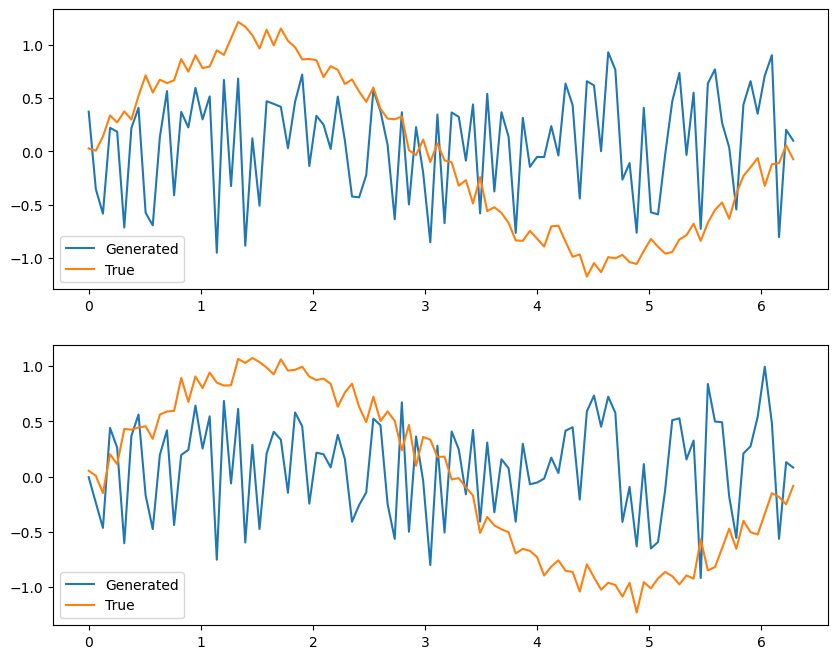

In [7]:
# Generate new samples
model.eval()
with torch.no_grad():
    sample_shape = (seq_length, num_features)
    generated_samples = model.p_sample_loop(sample_shape).cpu().numpy()

# Plot the generated sample against the true data
fig, axs = plt.subplots(num_features, 1, figsize=(10, 8))

for i in range(num_features):
    axs[i].plot(np.linspace(0, 2 * np.pi, seq_length), generated_samples[ :, i], label='Generated')
    axs[i].plot(np.linspace(0, 2 * np.pi, seq_length), synthetic_data[1, :, i], label='True')
    axs[i].legend()

plt.show()